In [ ]:
import os
USING_COLAB = 'COLAB_GPU' in os.environ
print('IT IS COLAB:', USING_COLAB)

IT IS COLAB: True


In [ ]:
if USING_COLAB:
    !pip install "setuptools>=45" setuptools_scm brian2 neurodynex3

if USING_COLAB:
    !apt-get install -y xvfb x11-utils
    !pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
    import pyvirtualdisplay


    _display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                        size=(1400, 900))
    _ = _display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


# Seminar 3. Neuromorphic control
## In class:
* OpenAI Gym. Classic control environments.
* Observations, action, reward
* Neuro controller
* Mutual inhibition for control
* Parametric tuning

## Homework:
* Explore the controller performance for "asymmetric" network where one of the neurons doesn't have sensor input and receives only synaptic connections from the other neuron.
* Create neurocontroller for continuous mountain car environment (https://gym.openai.com/envs/MountainCarContinuous-v0/). The continuous actions may be represented by firing rates (rate coding) or by neuron numbers (spatial coding).
* Optimize the controller parameters from scratch. You may use optimize.differential_evolution algorithm

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#scipy.optimize.differential_evolution
* Optimize parameters using HyperOpt https://hyperopt.github.io/hyperopt/

In [ ]:
def plot_v_spikes(v_mon, s_mon, t_bounds=None):
    b2.figure(figsize=(12,4))
    b2.subplot(121)
    b2.plot(v_mon.t/b2.ms, v_mon.v[0], label='left')
    b2.plot(v_mon.t/b2.ms, v_mon.v[1], label='right')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('v')
    b2.legend();
    b2.subplot(122)
    b2.plot(s_mon.t/b2.ms,s_mon.i, '.k')
    if t_bounds:
        b2.xlim(t_bounds)
    b2.xlabel('Time (ms)')
    b2.ylabel('Neuron num') 

## CartPole

### 1. OpenAI Gym
Here we explore the most basic environment, CartPole (https://gym.openai.com/envs/CartPole-v1/).

Observation: 
        Type: Box(4)
        
        Num	 Observation              Min             Max
        
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24 deg        24 deg
        3	Pole Velocity At Tip      -Inf            Inf
        
Actions:
        Type: Discrete(2)
        
        Num	Action
        0	Push cart to the left
        1	Push cart to the right
        
Reward:

        Reward is 1 for every step taken, including the termination step

In [ ]:
import gym
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm

def control_cartpole(controller, steps_count=200, show=True, print_log=True, 
                     sleep_time=None, stop_after_done=True, weights=[0, 0, 0, 0],
                     coord=0,
                     make_env=lambda:gym.make("CartPole-v1")):
    env = make_env()
    try:
        obs = env.reset()
        R = 0
        printed_data = ''
        if print_log:
            to_print = "Step \t CartPosition CartVelocity PoleAngle PoleVelocity \tAction"
            print(to_print)
            printed_data += to_print + '\n'
        for i in range(steps_count):
            obs[0] -= coord
            action = controller.next_action(obs)
            if print_log:
                to_print = f"{i}\t{obs[0]:12.4f}{obs[1]:12.4f}{obs[2]:12.4f}{obs[3]:12.4f}\t{action}"
                print(to_print)
                printed_data += to_print + '\n'
            obs, reward, done, _ = env.step(action)
            CartPosition, CartVelocity, PoleAngle, PoleVelocity = obs
            reward -= weights[0] * abs(CartPosition - coord) + weights[1] * abs(CartVelocity) + weights[2] * abs(PoleAngle) + weights[3] * abs(PoleVelocity)
            R += reward
            if show:
                if USING_COLAB:
                    clear_output(wait=True)
                    plt.imshow(env.render(mode='rgb_array'))
                    # display.display(plt.gcf())
                    plt.show()
                    print(printed_data, end='')
                else:
                    env.render()
                if sleep_time:
                    time.sleep(sleep_time)
            if stop_after_done and done:
                break
        if print_log:
            print(f"Finished in {i+1} steps")
            print(f"Total reward = {R}")
    except Exception:
        raise
    finally:
        env.close()
    return R

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [ ]:
class RandomController:
    def __init__(self):
        self.action_space = gym.spaces.Discrete(2)
        
    def next_action(self, observation):
        return self.action_space.sample()

In [ ]:
control_cartpole(RandomController())

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	     -0.0058     -0.0449      0.0318     -0.0397	0
1	     -0.0067     -0.2404      0.0310      0.2629	0
2	     -0.0115     -0.4360      0.0362      0.5651	1
3	     -0.0202     -0.2414      0.0476      0.2841	1
4	     -0.0251     -0.0470      0.0532      0.0068	0
5	     -0.0260     -0.2428      0.0534      0.3158	0
6	     -0.0309     -0.4387      0.0597      0.6248	0
7	     -0.0396     -0.6346      0.0722      0.9357	1
8	     -0.0523     -0.4405      0.0909      0.6665	1
9	     -0.0611     -0.2467      0.1042      0.4038	0
10	     -0.0661     -0.4432      0.1123      0.7274	0
11	     -0.0749     -0.6397      0.1268      1.0532	0
12	     -0.0877     -0.8362      0.1479      1.3829	0
13	     -0.1044     -1.0328      0.1756      1.7179	1
Finished in 14 steps
Total reward = 14.0


14.0

### 2. Neuro controller
Here we create two LIF "motor neurons" for "Left" and "Right" actions.
The synaptic inputs come from the observations.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import brian2 as b2
import numpy as np
import random

class NeuroController:
    LEFT = 0
    RIGHT = 1
        
    def __init__(self, tau, w_sensor, I_tonic):
        # b2.start_scope() # clear the Brian scope
        eqs = '''
            dv/dt = (inp-v+I_t)/tau: 1
            inp : 1
            tau : second
            I_t : 1
            '''
        G = b2.NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='linear')
        self.neurons = G
        self.neurons.tau = tau
        self.neurons.v = [0,0]
        self.neurons.I_t = I_tonic
        self.w_sensor = w_sensor
        self.T_step = 1/50 * b2.second
        self.spike_mon = b2.SpikeMonitor(G)
        self.v_mon = b2.StateMonitor(G, "v", record=True)
        self.net = b2.Network(self.neurons, self.spike_mon, self.v_mon)
    
    def next_action(self, observation):
        self.neurons.inp = observation@self.w_sensor
        prev_spikes = np.array(self.spike_mon.count)
        self.net.run(self.T_step, namespace=self.neurons.namespace)
        new_spikes = self.spike_mon.count - prev_spikes
        left = new_spikes[NeuroController.LEFT]
        right = new_spikes[NeuroController.RIGHT]
        if right > left:
            return NeuroController.RIGHT
        elif right < left:
            return NeuroController.LEFT
        else:
            return random.choice([NeuroController.LEFT, NeuroController.RIGHT])


### 3. Input weights and tonic drive

* explore how sensor weights influence control
* add tonic drive current I_ton to both neurons

#### Hint: 
The important parameters are CartVelocity and PoleAngle

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	     -0.0174      0.0014      0.0257     -0.0483	1
1	     -0.0173      0.1961      0.0247     -0.3327	1
2	     -0.0134      0.3909      0.0181     -0.6175	1
3	     -0.0056      0.5857      0.0057     -0.9045	0
4	      0.0061      0.3905     -0.0124     -0.6100	0
5	      0.0139      0.1956     -0.0246     -0.3212	0
6	      0.0179      0.0008     -0.0310     -0.0364	0
7	      0.0179     -0.1938     -0.0317      0.2464	0
8	      0.0140     -0.3885     -0.0268      0.5289	0
9	      0.0062     -0.5832     -0.0162      0.8130	1
10	     -0.0054     -0.3879      0.0001      0.5153	1
11	     -0.0132     -0.1928      0.0104      0.2226	1
12	     -0.0171      0.0022      0.0148     -0.0668	1
13	     -0.0170      0.1971      0.0135     -0.3547	1
14	     -0.0131      0.3920      0.0064     -0.6431	0
15	     -0.0052      0.1968     -0.0065     -0.3485	0
16	     -0.0013      0.0018     -0.0134     -0.0578	0
17	     -0.0013     -0.1931 

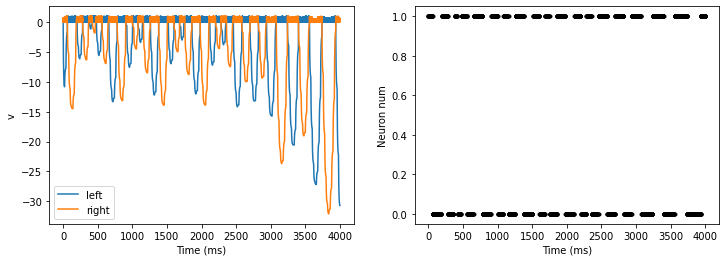

In [ ]:
from numpy.random import default_rng
rng = default_rng()
b2.start_scope()
tau = [5*b2.ms, 5*b2.ms]

# Vary the weight from -1(1) to -100 (100)
# observation = [CartPosition, CartVelocity, PoleAngle, PoleVelocity]
# action

# For left
wCartPosition = -20  # !!! < 0 with other !!! > 0 to center 
wCartVelocity = 0.1  # > 0 to low speed
wPoleAngle = -500  # < 0 to normal
wPoleVelocity = -10  # < 0 to normal

w_sensor = np.array([[wCartPosition, wCartVelocity, wPoleAngle, wPoleVelocity],
                     [-wCartPosition, -wCartVelocity,  -wPoleAngle, -wPoleVelocity]]).T
# Add tonic current I_t to neurons in NeuroController like that:
I_tonic = 1
controller = NeuroController(tau, w_sensor, I_tonic)

control_cartpole(controller, steps_count=200, sleep_time=0.01, stop_after_done=True)
plot_v_spikes(controller.v_mon, controller.spike_mon)

### Control by a half-center oscillator
* Add inhibitory synapses to the controller network
* Explore how mutual inhibition influence control
* Cut sensor inputs to one of the neurons

In [ ]:
class HCOController(NeuroController):
        
    def __init__(self, tau, w_sensor, w_syn, I_tonic):
        NeuroController.__init__(self, tau, w_sensor, I_tonic)
        # self.neurons.add_attribute("w_syn")
        # self.neurons.w_syn = w_syn
        self.neurons.namespace.update({'w_syn': w_syn})
        S = b2.Synapses(self.neurons, self.neurons, on_pre='v_post += w_syn')
        S.connect(i=0, j=1)
        S.connect(i=1, j=0)
        self.net.add(S)

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	     -0.0433     -0.0066      0.0430      0.0032	1
1	     -0.0434      0.1879      0.0430     -0.2756	1
2	     -0.0397      0.3824      0.0375     -0.5544	1
3	     -0.0320      0.5770      0.0264     -0.8351	1
4	     -0.0205      0.7717      0.0097     -1.1193	0
5	     -0.0051      0.5765     -0.0126     -0.8236	0
6	      0.0065      0.3815     -0.0291     -0.5349	0
7	      0.0141      0.1868     -0.0398     -0.2515	0
8	      0.0178     -0.0077     -0.0448      0.0283	0
9	      0.0177     -0.2022     -0.0443      0.3065	0
10	      0.0136     -0.3966     -0.0382      0.5849	0
11	      0.0057     -0.5912     -0.0265      0.8653	0
12	     -0.0061     -0.7859     -0.0091      1.1496	1
13	     -0.0218     -0.5907      0.0138      0.8541	1
14	     -0.0336     -0.3958      0.0309      0.5658	1
15	     -0.0416     -0.2011      0.0422      0.2830	1
16	     -0.0456     -0.0066      0.0479      0.0039	1
17	     -0.0457      0.1878 

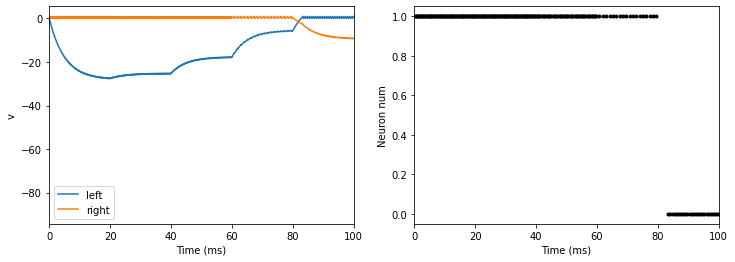

In [ ]:
rng = default_rng()
b2.start_scope()
tau = [5*b2.ms, 5*b2.ms]

# For left
wCartPosition = -20  # !!! < 0 with other !!! > 0 to center 
wCartVelocity = 0.1  # > 0 to low speed
wPoleAngle = -500  # < 0 to normal
wPoleVelocity = -10  # < 0 to normal

w_sensor = np.array([[wCartPosition, wCartVelocity, wPoleAngle, wPoleVelocity],
                     [-wCartPosition, -wCartVelocity,  -wPoleAngle, -wPoleVelocity]]).T

controller = HCOController(tau, w_sensor, w_syn=-0.5, I_tonic=1)

control_cartpole(controller, steps_count=1000, sleep_time=0.01, stop_after_done=True)
plot_v_spikes(controller.v_mon, controller.spike_mon, t_bounds=(0, 100))

### Parametric tuning
Here we will find optimal parameters for the controller by the optimization algorithm


In [ ]:
from itertools import product

def get_bounds(bounds_dict, search_type='grid'):
    if search_type == 'evo':
        return list(bounds_dict.values())
    elif search_type == 'grid':
        params = []
        for key in bounds_dict:
            params.append(np.linspace(bounds_dict[key][0], bounds_dict[key][1], 5))
        return set(product(*params))
    else:
        raise RuntimeError('Wrong search type')

In [ ]:
def create_controller(x):
    b2.start_scope()
    tau = [5*b2.ms, 5*b2.ms]
    I_tonic = x[0]
    w_syn = x[1]
    w_sensor = np.array([[x[2], x[3], x[4], x[5]],
                     [-x[2], -x[3],  -x[4], -x[5]]]).T
    return HCOController(tau, w_sensor, w_syn, I_tonic)
    

def obj_fun(x, num_run=3):
    total_R = 0
    for _ in range(num_run):
        total_R += control_cartpole(create_controller(x), steps_count=1000,
                                    show=True, print_log=False)
    print('\rR:', int(total_R/num_run), 'Current params:', str(x), end='')
    return total_R/num_run

In [ ]:
bounds_dict = {
    'I_t': (0, 3),
    'w_syn': (-1, 0),
    'wCartPosition': (10, 10),
    'wCartVelocity': (0, 300),
    'wPoleAngle': (-300, 0),
    'wPoleVelocity': (-10, -10),
}

In [ ]:
params = get_bounds(bounds_dict)

reward_idx = 0
F = []
best = None
for x in tqdm(params):
    F += [(obj_fun(x), x[0], x[1], x[2], x[3], x[4], x[5])]
    if best is None or max(F, key=lambda x: x[reward_idx])[0] > best[0]:
        best = max(F, key=lambda x: x[reward_idx])
        print('\rLast best:', best, end='\n')
# print(F)
best = max(F, key=lambda x: x[reward_idx])
print(f"\rBest solution: {best}")

All 420 params


Current params:	 (0, -1, 0, -10, -100, 0)
New best: (0, -1, 10.1, 0, -10, -100, 0)
Current params:	 (0, -1, 0, -5, -100, 0)
New best: (0, -1, 16.3, 0, -5, -100, 0)
Current params:	 (0, -1, 0, 0, -100, 0)
New best: (0, -1, 50.8, 0, 0, -100, 0)
Current params:	 (0, -1, 0, 0, -50, 0)
New best: (0, -1, 61.2, 0, 0, -50, 0)
Current params:	 (0, -1, 0, 5, -100, 0)
New best: (0, -1, 361.9, 0, 5, -100, 0)
Current params:	 (0, -0.5, 0, 5, -100, 0)
New best: (0, -0.5, 407.6, 0, 5, -100, 0)
Current params:	 (1, -0.25, 0, 5, -100, 0)
New best: (1, -0.25, 422.3, 0, 5, -100, 0)
Current params:	 (2, -1, 0, 5, -100, 0)
New best: (2, -1, 425.8, 0, 5, -100, 0)
Current params:	 (2, 0, 0, 5, -100, 0)
New best: (2, 0, 434.8, 0, 5, -100, 0)
Current params:	 (2, 0, 0, 10, 100, 0)
Best solution: I_tonic=2, w_syn=0. Reward=434.8


In [ ]:
from scipy import optimize as opt

bounds = list({
    'I_t': (0, 3),
    'w_syn': (-1, 0),
    'wCartPosition': (0, 10),
    'wCartVelocity': (0, 300),
    'wPoleAngle': (-300, 0),
    'wPoleVelocity': (-10, 0),
}.values())

res = opt.differential_evolution(obj_fun, bounds, maxiter=1)
print(f"Best solution: I_tonic={res.x[0]}, w_syn={res.x[1]}. Reward={res.fun[end]}")
res_hco = create_controller(res.x)
control_cartpole(res_hco, show=True, print_log=False)
plot_v_spikes(controller.v_mon, controller.spike_mon)

Reward: 99 Current params:	 [   2.70396693   -0.42344744    6.36904632   64.94299529 -225.7345898
   -4.11914005]
Reward: 65 Current params:	 [   1.52643202   -0.44497608    6.47841376  100.83327114 -107.25326297
   -4.93039647]
Reward: 79 Current params:	 [   0.68075193   -0.61858234    8.95362536   95.22653248 -280.89227376
   -6.76592889]
Reward: 95 Current params:	 [   2.61519464   -0.31551384    2.48283128  236.53523603 -190.01179352
   -4.24350286]
Reward: 57 Current params:	 [   2.15121425   -0.81221631    6.24607049  226.75463736 -134.51992147
   -8.98426557]
Reward: 295 Current params:	 [ 2.77920606e+00 -8.30653032e-02  1.86237182e+00  2.88710124e+01
 -2.51391074e+02 -3.90285176e+00]
Reward: 100 Current params:	 [  0.94025785  -0.9873014    8.04218315 137.86883207 -96.72098689
  -1.72543854]
Reward: 64 Current params:	 [   0.4848204    -0.86532349    9.36626981  257.63262938 -119.94369324
   -4.5061866 ]
Reward: 104 Current params:	 [   0.74662965   -0.89908929    7.18907343  

KeyboardInterrupt: ignored

## ContCartPole

### Random

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import time
import numpy as np
from cartpolecont import CartPoleContEnv
%matplotlib inline

class RandomContController:
    def __init__(self):
        pass
        
    def next_action(self, observation):
        return np.random.random() * 2 - 1
    
def control_cont_cartpole(*args, **kwargs):
    return control_cartpole(*args, **kwargs, make_env=CartPoleContEnv)

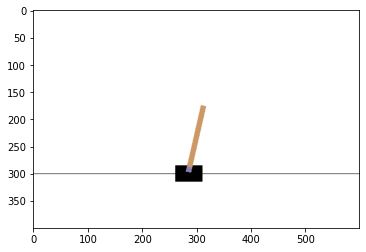

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	     -0.0452     -0.0467      0.0066      0.0336	-0.3842280552097941
1	     -0.0462     -0.1218      0.0073      0.1482	0.12772545206533814
2	     -0.0486     -0.0969      0.0103      0.1131	-0.28985007620759284
3	     -0.0505     -0.1536      0.0125      0.2012	0.6616999053410269
4	     -0.0536     -0.0247      0.0166      0.0115	-0.589154352309984
5	     -0.0541     -0.1399      0.0168      0.1891	0.04757924369453148
6	     -0.0569     -0.1309      0.0206      0.1805	-0.18574824620926433
7	     -0.0595     -0.1674      0.0242      0.2413	0.20407310483608665
8	     -0.0629     -0.1279      0.0290      0.1892	0.1284243113481296
9	     -0.0654     -0.1033      0.0328      0.1608	0.06929266863471195
10	     -0.0675     -0.0902      0.0360      0.1509	0.059015648450644775
11	     -0.0693     -0.0792      0.0390      0.1450	0.06900475026354003
12	     -0.0709     -0.0663      0.0419      0.1371	-0.3386964238818426
13	     -0

83.0

In [ ]:
control_cont_cartpole(RandomContController())

### Neuro

In [ ]:
import brian2 as b2
import numpy as np
# from numpy.random import default_rng

class ContNeuroController:
    MAX_SPIKES = 200
    LEFT = 0
    RIGHT = 1
        
    def __init__(self, tau, w_sensor, I_tonic):
        # b2.start_scope() # clear the Brian scope
        eqs = '''
            dv/dt = (inp-v+I_t)/tau: 1
            inp : 1
            tau : second
            I_t : 1
            '''
        G = b2.NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='linear')
        self.neurons = G
        self.neurons.tau = tau
        self.neurons.v = [0,0]
        self.neurons.I_t = I_tonic
        self.w_sensor = w_sensor
        self.T_step = 1/50 * b2.second
        self.spike_mon = b2.SpikeMonitor(G)
        self.v_mon = b2.StateMonitor(G, "v", record=True)
        self.net = b2.Network(self.neurons, self.spike_mon, self.v_mon)
    
    def next_action(self, observation):
        global max_spikes
        self.neurons.inp = observation@self.w_sensor
        prev_spikes = np.array(self.spike_mon.count)
        self.net.run(self.T_step, namespace=self.neurons.namespace)
        new_spikes = self.spike_mon.count - prev_spikes
        left = new_spikes[self.LEFT]
        right = new_spikes[self.RIGHT]
        if max(left, right) > self.MAX_SPIKES:
            print(f'\n\n>>>>>>>> MAX SPIKES error: max is {max(left, right)}\n\n')
            if left > self.MAX_SPIKES:
                left = self.MAX_SPIKES
            if right > self.MAX_SPIKES:
                right = self.MAX_SPIKES
        if right > left:
            return right / self.MAX_SPIKES
        elif right < left:
            return - left / self.MAX_SPIKES
        else:
            return 0  #np.random.random() * 2 - 1


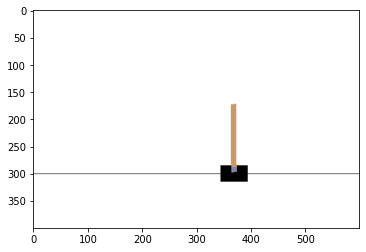

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	     -0.0391      0.0421     -0.0150      0.0476	-0.09
1	     -0.0383      0.0247     -0.0140      0.0692	-0.08
2	     -0.0378      0.0093     -0.0126      0.0882	-0.075
3	     -0.0376     -0.0051     -0.0109      0.1062	-0.06
4	     -0.0377     -0.0167     -0.0087      0.1203	-0.05
5	     -0.0380     -0.0263     -0.0063      0.1322	-0.035
6	     -0.0386     -0.0331     -0.0037      0.1405	-0.02
7	     -0.0392     -0.0369     -0.0009      0.1452	0.005
8	     -0.0400     -0.0359      0.0020      0.1434	0.025
9	     -0.0407     -0.0311      0.0049      0.1368	0.04
10	     -0.0413     -0.0233      0.0076      0.1266	0.05
11	     -0.0418     -0.0137      0.0102      0.1144	0.06
12	     -0.0420     -0.0021      0.0125      0.1000	0.065
13	     -0.0421      0.0104      0.0145      0.0849	0.08
14	     -0.0419      0.0258      0.0162      0.0661	0.075
15	     -0.0414      0.0402      0.0175      0.0492	0.085
16	     -0.0406     

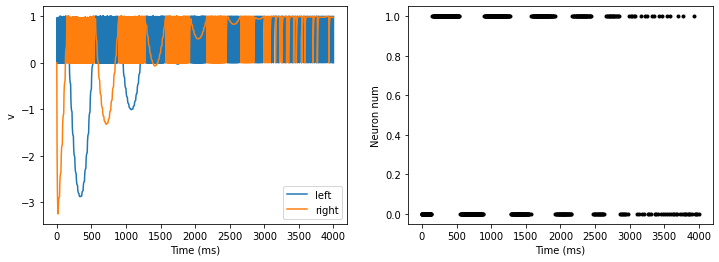

In [ ]:
# rng = default_rng()
b2.start_scope()
tau = [5*b2.ms, 5*b2.ms]

# For left
wCartPosition = -5  # > 0 to center
wCartVelocity = 10  # > 0 to low speed
wPoleAngle = -250  # < 0 to normal
wPoleVelocity = -1  # < 0 to normal

w_sensor = np.array([[wCartPosition, wCartVelocity, wPoleAngle, wPoleVelocity],
                     [-wCartPosition, -wCartVelocity,  -wPoleAngle, -wPoleVelocity]]).T
I_tonic = 1
controller = ContNeuroController(tau, w_sensor, I_tonic)

control_cont_cartpole(controller, steps_count=200, sleep_time=0.01, 
                      stop_after_done=True, print_log=True,
                      weights=[1, 0, 10, 0])
plot_v_spikes(controller.v_mon, controller.spike_mon)

### HCO

In [ ]:
class ContHCOController(ContNeuroController):
        
    def __init__(self, tau, w_sensor, w_syn, I_tonic):
        ContNeuroController.__init__(self, tau, w_sensor, I_tonic)
        # self.neurons.add_attribute("w_syn")
        # self.neurons.w_syn = w_syn
        self.neurons.namespace.update({'w_syn': w_syn})
        S = b2.Synapses(self.neurons, self.neurons, on_pre='v_post += w_syn')
        S.connect(i=0, j=1)
        S.connect(i=1, j=0)
        self.net.add(S)

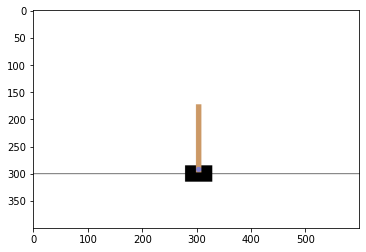

Step 	 CartPosition CartVelocity PoleAngle PoleVelocity 	Action
0	     -0.0167      0.0015     -0.0207      0.0105	-0.2
1	     -0.0167     -0.0373     -0.0205      0.0625	-0.2
2	     -0.0174     -0.0760     -0.0193      0.1145	-0.165
3	     -0.0189     -0.1079     -0.0170      0.1567	-0.14
4	     -0.0211     -0.1350     -0.0138      0.1924	-0.115
5	     -0.0238     -0.1572     -0.0100      0.2216	-0.07
6	     -0.0269     -0.1707     -0.0056      0.2390	-0.025
7	     -0.0304     -0.1755     -0.0008      0.2445	0.035
8	     -0.0339     -0.1687      0.0041      0.2340	0.08
9	     -0.0372     -0.1531      0.0088      0.2119	0.125
10	     -0.0403     -0.1289      0.0130      0.1781	0.145
11	     -0.0429     -0.1008      0.0166      0.1398	0.165
12	     -0.0449     -0.0688      0.0194      0.0967	0.2
13	     -0.0463     -0.0301      0.0213      0.0443	0.2
14	     -0.0469      0.0086      0.0222     -0.0075	0.2
15	     -0.0467      0.0474      0.0221     -0.0590	0.17
16	     -0.0458      0.08

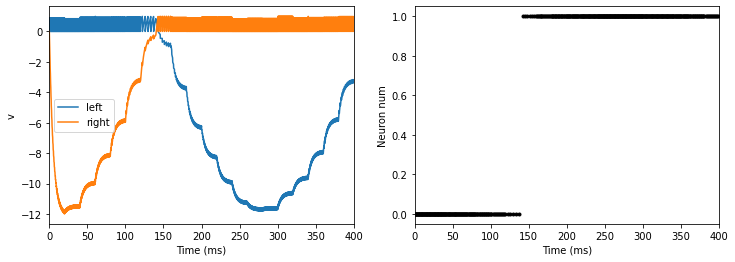

In [ ]:
# rng = default_rng()
b2.start_scope()
tau = [5*b2.ms, 5*b2.ms]

# For left
wCartPosition = -20  # !!! < 0 with other !!! > 0 to center 
wCartVelocity = 0.1  # > 0 to low speed
wPoleAngle = -500  # < 0 to normal
wPoleVelocity = -10  # < 0 to normal

w_sensor = np.array([[wCartPosition, wCartVelocity, wPoleAngle, wPoleVelocity],
                     [-wCartPosition, -wCartVelocity,  -wPoleAngle, -wPoleVelocity]]).T

controller = ContHCOController(tau, w_sensor, w_syn=-0.25, I_tonic=1)

control_cont_cartpole(controller, steps_count=200, sleep_time=0.01, 
                      coord=0, stop_after_done=True)
plot_v_spikes(controller.v_mon, controller.spike_mon)

In [ ]:
from itertools import product

def get_bounds(bounds_dict, search_type='grid'):
    if search_type == 'evo':
        return list(bounds_dict.values())
    elif search_type == 'grid':
        params = []
        for key in bounds_dict:
            params.append(np.linspace(bounds_dict[key][0], bounds_dict[key][1], 5))
        return set(product(*params))
    else:
        raise RuntimeError('Wrong search type')

In [ ]:
from functools import lru_cache

def create_cont_controller(x):
    b2.start_scope()
    tau = [5*b2.ms, 5*b2.ms]
    I_tonic = x[0]
    w_syn = x[1]
    w_sensor = np.array([[x[2], x[3], x[4], x[5]],
                     [-x[2], -x[3],  -x[4], -x[5]]]).T
    return ContHCOController(tau, w_sensor, w_syn, I_tonic)
    

# @lru_cache(maxsize=1024)
def cont_obj_fun(x, num_run=3, search_type='grid'):
    total_R = 0
    for _ in range(num_run):
        total_R += control_cont_cartpole(create_cont_controller(x), steps_count=1000,
                                    show=False, print_log=False,
                                    weights=[1, 0, 10, 0])
    # print('\rR:', int(total_R/num_run), 'Current params:', str(x), end='\n')
    return total_R / num_run * (-1 if search_type == 'evo' else 1)

In [ ]:
bounds_dict = {
    'I_t': (0, 3),
    'w_syn': (-1, 0),
    'wCartPosition': (-1000, 0),
    'wCartVelocity': (0, 500),
    'wPoleAngle': (-1000, 0),
    'wPoleVelocity': (0, -10),
}

In [ ]:
params = get_bounds(bounds_dict)

reward_idx = 0
F = []
best = None
for x in params:
    F += [(cont_obj_fun(x), x[0], x[1], x[2], x[3], x[4], x[5])]
    if best is None or max(F, key=lambda x: x[reward_idx])[0] > best[0]:
        best = max(F, key=lambda x: x[reward_idx])
        print('\rLast best:', best, end='\n')
# print(F)
best = max(F, key=lambda x: x[reward_idx])
print(f"\rBest solution: {best}")

  0%|          | 0/6 [00:00<?, ?it/s]

New best: [2.7, -0.9, 0, 0, -200, -5] R: -909.4078203188564
Iter 5

KeyboardInterrupt: ignored

In [ ]:
from scipy import optimize as opt

bounds = get_bounds(bounds_dict, 'evo')

res = opt.differential_evolution(cont_obj_fun, bounds, args=(3, 'evo'), maxiter=25, popsize=10, workers=1, disp=True)#, x0=[1, -0.25, -20, 1, -500, -10])
print(f"Best solution: I_tonic={res.x}. Reward={res.fun}")
res_hco = create_cont_controller(res.x)
control_cont_cartpole(res_hco, show=True, print_log=False)
plot_v_spikes(controller.v_mon, controller.spike_mon)

differential_evolution step 1: f(x)= -536.173
differential_evolution step 2: f(x)= -657.028
differential_evolution step 3: f(x)= -657.028
differential_evolution step 4: f(x)= -657.028
differential_evolution step 5: f(x)= -727.675
differential_evolution step 6: f(x)= -881.753
